# # Input Driven Observations ("GLM-HMM")
#
Notebook prepared by Zoe Ashwood: feel free to email me with feedback or questions (zashwood at cs dot princeton dot edu).

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}} \tag{1}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}} \tag{2}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}. \tag{3}
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}. \tag{4}
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

# 1. Set up

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

from multiglm.visualizations.ssm_visualizer import *

npr.seed(0)

%load_ext autoreload
%autoreload 2

sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Input Driven Observations- Bernoulli

These are standard stationary transitions.

### 2a. Initialize GLM-HMM

In [18]:
# Set the parameters of the GLM-HMM
num_states = 3  # number of discrete states
obs_dim = 1  # number of observed dimensions
num_categories = 2  # number of categories for output
input_dim = 2  # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

### 2b. Specify the parameters of the Generative Model

In [19]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(
    np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]])
)
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

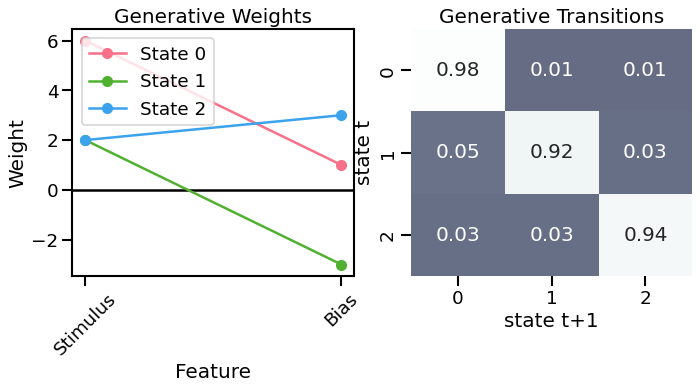

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=80)
plot_bernoulli_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax[0],
    title="Generative Weights",
)
plot_transition_matrix(gen_log_trans_mat, ax=ax[1], title="Generative Transitions")

### 2c. Create External Input Sequences

In [21]:
num_sess = 20  # number of example sessions
num_trials_per_sess = 100  # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim))  # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:, :, 0] = np.random.choice(
    stim_vals, (num_sess, num_trials_per_sess)
)  # generate random sequence of stimuli
inpts = list(inpts)  # convert inpts to correct format
len(inpts), inpts[0].shape

(20, (100, 2))

### 2d. Simulate states and observations with generative model

In [22]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

len(true_latents), true_latents[0].shape

(20, (100,))

In [23]:
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts)
print("true ll = " + str(true_ll))

true ll = -900.7834782398646


## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation
Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [24]:
new_glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

N_iters = 200  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(
    true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4
)

Converged to LP: -895.3:  13%|█▎        | 26/200 [00:00<00:04, 35.41it/s]


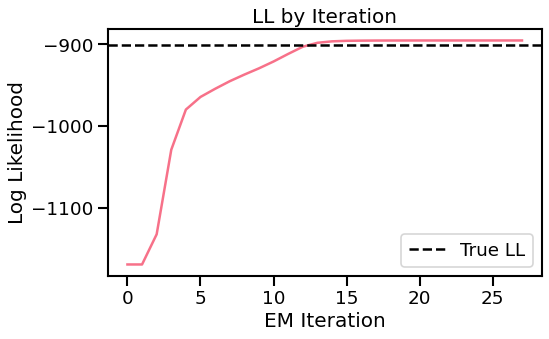

In [25]:
plot_log_likelihood_over_iters(fit_ll, true_ll=true_ll)

### 3b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we may first need to permute the states of the fit GLM-HMM relative to the generative model. One way to do this uses the find_permutation function from ssm:

In [26]:
new_glmhmm.permute(
    find_permutation(
        true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])
    )
)

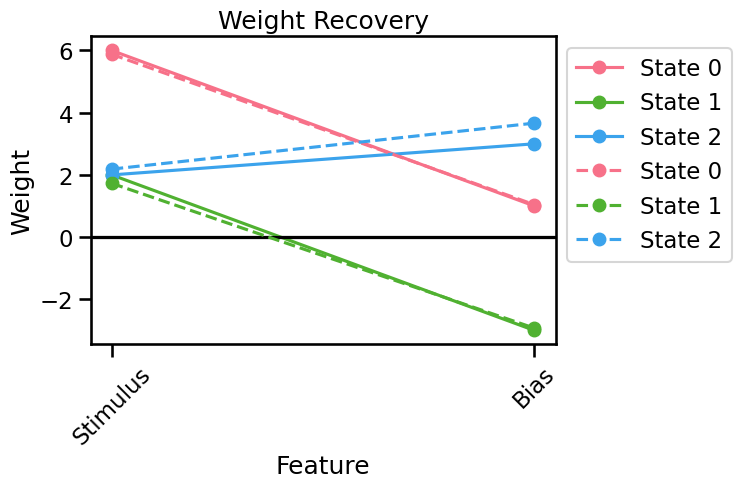

In [27]:
recovered_weights = new_glmhmm.observations.params
fig, ax = plt.subplots(figsize=(6, 4))
plot_bernoulli_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax,
)
plot_bernoulli_weights_by_state(
    recovered_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax,
    title="Weight Recovery",
    linestyle="--",
)

ax.legend(bbox_to_anchor=(1, 1))

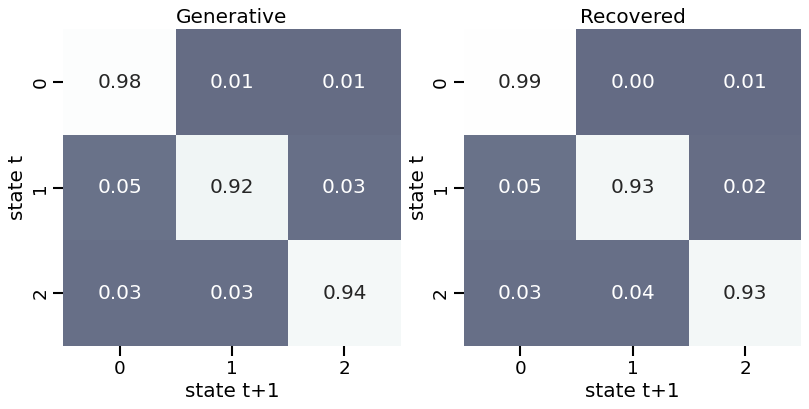

In [28]:
# Example usage
fig, ax = plt.subplots(
    1, 2, figsize=(10, 5), dpi=80, facecolor="w", edgecolor="k", constrained_layout=True
)
plot_transition_matrix(gen_log_trans_mat, ax[0], title="Generative")
plot_transition_matrix(new_glmhmm.transitions.log_Ps, ax[1], title="Recovered")

## 3c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.



In [29]:
posterior_state_probs = get_posterior_state_probs(
    new_glmhmm, true_choices, inputs=inpts
)

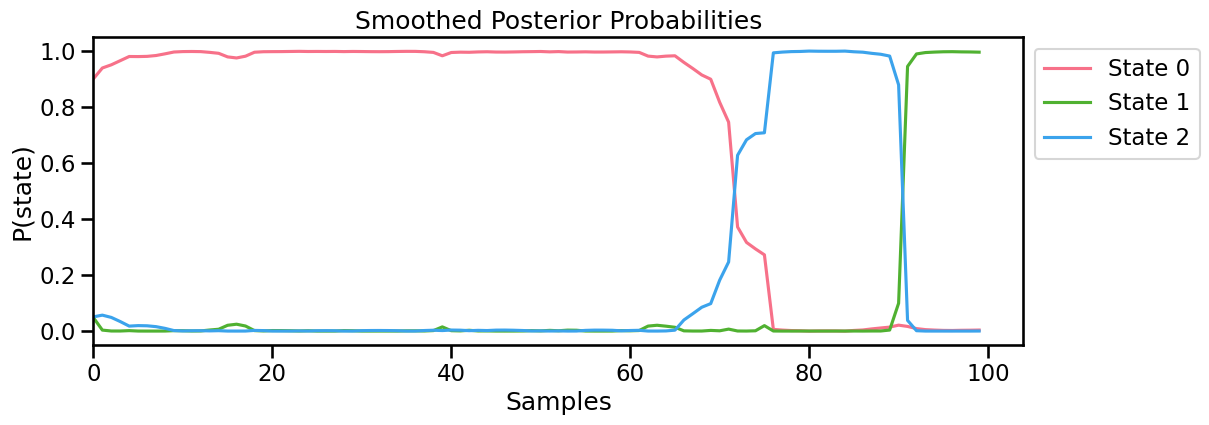

In [30]:
session_to_plot = 0
plot_state_posterior(posterior_state_probs[session_to_plot])

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [31]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_state_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis=1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies / np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

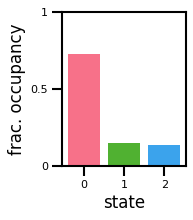

In [32]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor="w", edgecolor="k")
for z, occ in enumerate(state_occupancies):
    plt.bar(
        z,
        occ,
        width=0.8,
    )
plt.ylim((0, 1))
plt.xticks([0, 1, 2], fontsize=10)
plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
plt.xlabel("state", fontsize=15)
plt.ylabel("frac. occupancy", fontsize=15)

## 4. Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the GLM-HMM in simulated data. In the small data regime, where we do not have many trials available to us, we may instead want to perform Maximum A Priori (MAP) Estimation in order to incorporate a prior term and restrict the range for the best fitting parameters. Unfortunately, what is meant by 'small data regime' is problem dependent and will be affected by the number of states in the generative GLM-HMM, and the specific parameters of the generative model, amongst other things. In practice, we may perform both Maximum Likelihood Estimation and MAP estimation and compare the ability of the fit models to make predictions on held-out data (see Section 5 on Cross-Validation below).  

The prior we consider for the GLM-HMM is the product of a Gaussian prior on the GLM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W, A) &= \mathcal{N}(W|0, \Sigma) \tag{5} \Pr(A|\alpha) \\&= \mathcal{N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1} \tag{6}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the GLM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.m

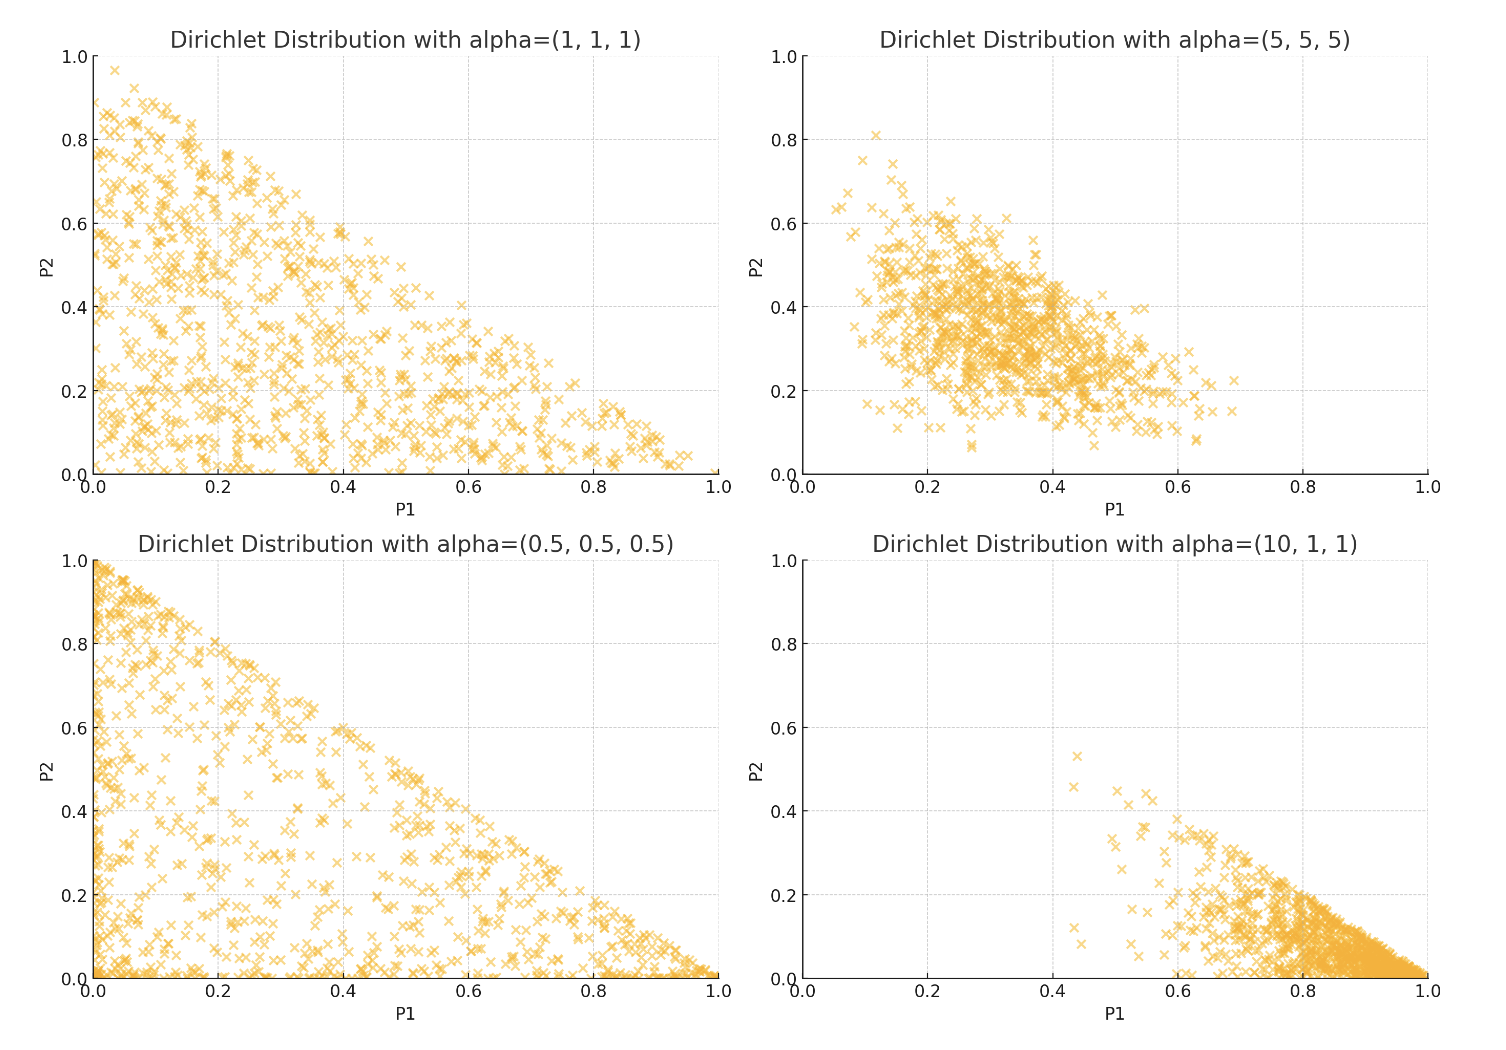
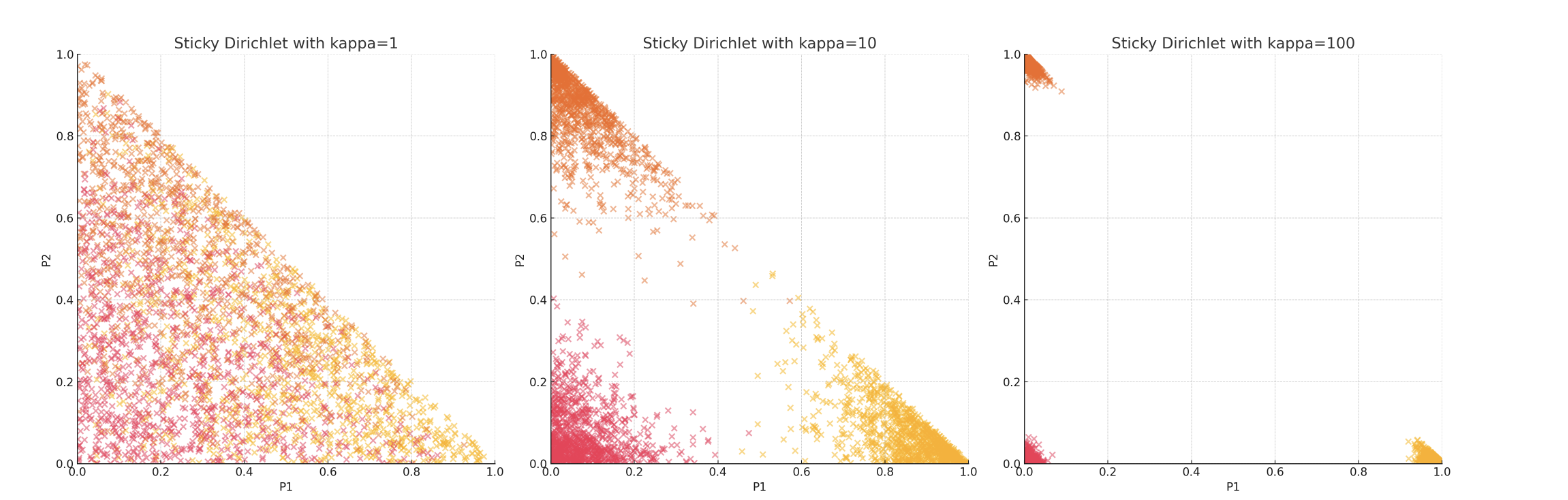

In [76]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
    transitions="sticky",
    transition_kwargs=dict(alpha=prior_alpha, kappa=0),
)

In [77]:
# Fit GLM-HMM with MAP estimation:
fit_map_ll = map_glmhmm.fit(
    true_choices, inputs=inpts, method="em", num_iters=200, tolerance=10**-4
)

Converged to LP: -889.6:  12%|█▎        | 25/200 [00:00<00:03, 45.97it/s]


Compare final likelihood of data with MAP estimation and MLE to likelihood under generative model (note: we cannot use log_probability that is output of fit function as this incorporates prior term, which is not comparable between generative and MAP models). We want to check that MAP and MLE likelihood values are higher than true likelihood; if they are not, this may indicate a poor initialization and that we should refit these models.

In [78]:
true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts)
map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts)

In [79]:
print("data for MLE fit: (prior + ll sums to fit ll) ")
new_glmhmm.log_prior(), mle_final_ll, fit_ll[-1]

data for MLE fit: (prior + ll sums to fit ll) 


(-46.96019557163333, -848.2981063522656, -895.2583202391617)

In [81]:
print("data for MAP fit: ")
map_glmhmm.log_prior(), map_final_ll, fit_map_ll[-1]

data for MAP fit: (does not perfectly sum) 


(-40.398451716328104, -849.1927907874954, -889.5911263281929)

Text(0, 0.5, 'loglikelihood')

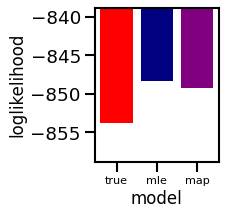

In [82]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor="w", edgecolor="k")
loglikelihood_vals = [true_likelihood, mle_final_ll, map_final_ll]
colors = ["Red", "Navy", "Purple"]
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width=0.8, color=colors[z])
plt.ylim((true_likelihood - 5, true_likelihood + 15))
plt.xticks([0, 1, 2], ["true", "mle", "map"], fontsize=10)
plt.xlabel("model", fontsize=15)
plt.ylabel("loglikelihood", fontsize=15)

## 5. Cross Validation
To assess which model is better - the model fit via Maximum Likelihood Estimation, or the model fit via MAP estimation - we can investigate the predictive power of these fit models on held-out test data sets.

### 5a. Create Test Set

In [83]:
# Create additional input sequences to be used as held-out test data
num_test_sess = 10
test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim))
test_inpts[:, :, 0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess))
test_inpts = list(test_inpts)
print(
    f"test input shapes, number of sessions: {len(test_inpts)}; trials, features: {test_inpts[0].shape}"
)

# Create set of test latents and choices to accompany input sequences:
test_latents, test_choices = [], []
for sess in range(num_test_sess):
    test_z, test_y = true_glmhmm.sample(num_trials_per_sess, input=test_inpts[sess])
    test_latents.append(test_z)
    test_choices.append(test_y)
print(
    f"test latent shapes, number of sessions: {len(test_latents)}; trials: {test_latents[0].shape}"
    f"\ntest choice shapes, number of sessions: {len(test_choices)}; trials: {test_choices[0].shape}"
)

test input shapes, number of sessions: 10; trials, features: (100, 2)
test latent shapes, number of sessions: 10; trials: (100,)
test choice shapes, number of sessions: 10; trials: (100, 1)


### 5b. Eval on Test Set

In [84]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts)
map_test_ll = map_glmhmm.log_likelihood(test_choices, inputs=test_inpts)

Text(0, 0.5, 'loglikelihood')

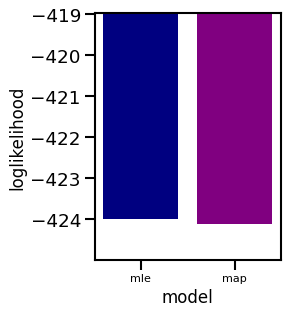

In [87]:
fig = plt.figure(figsize=(3, 4), dpi=80, facecolor="w", edgecolor="k")
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ["Navy", "Purple"]
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width=0.8, color=colors[z])
plt.ylim((mle_test_ll - 1, mle_test_ll + 5))
plt.xticks([0, 1], ["mle", "map"], fontsize=10)
plt.xlabel("model", fontsize=15)
plt.ylabel("loglikelihood", fontsize=15)

> Note given this random seed, I am unable to reproduce Zoe's result. MAP should be smaller than MLE in this scenario but alas.

Here we see that the model fit with MAP estimation achieves higher likelihood on the held-out dataset than the model fit with MLE, so we would choose this model as the best model of animal decision-making behavior (although we'd probably want to perform multiple fold cross-validation to be sure that this is the case in all instantiations of test data).

Let's finish by comparing the retrieved weights and transition matrices from MAP estimation to the generative parameters.

In [88]:
map_glmhmm.permute(
    find_permutation(
        true_latents[0], map_glmhmm.most_likely_states(true_choices[0], input=inpts[0])
    )
)

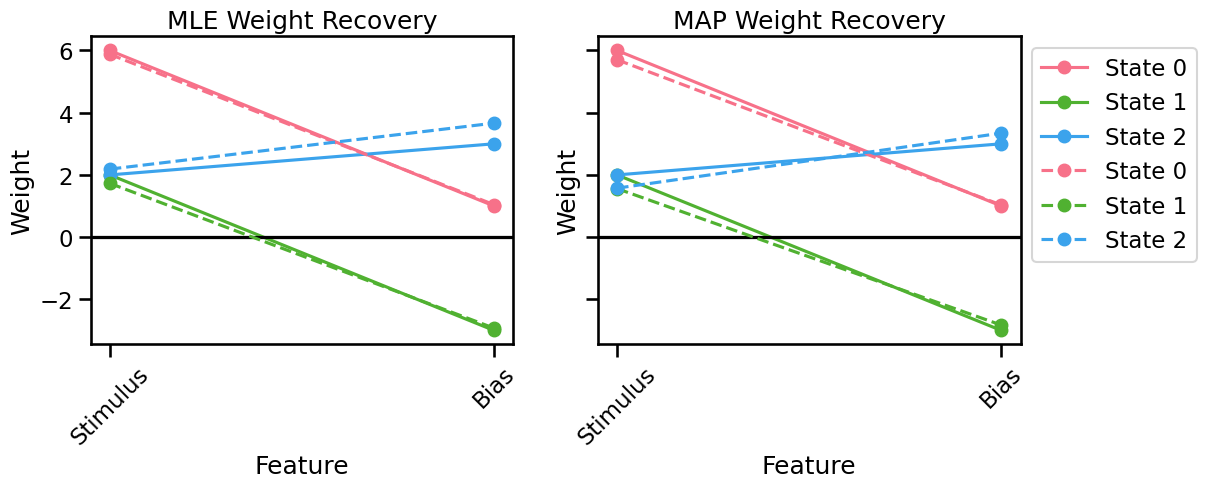

In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# MLE (left plot)
mle_weights = new_glmhmm.observations.params
plot_bernoulli_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax[0],
)
plot_bernoulli_weights_by_state(
    mle_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax[0],
    title="MLE Weight Recovery",
    linestyle="--",
)
ax[0].get_legend().remove()


# MAP (right plot)
map_weights = map_glmhmm.observations.params
plot_bernoulli_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax[1],
)
plot_bernoulli_weights_by_state(
    map_weights,
    feature_names=["Stimulus", "Bias"],
    ax=ax[1],
    title="MAP Weight Recovery",
    linestyle="--",
)

ax[1].legend(bbox_to_anchor=(1, 1))

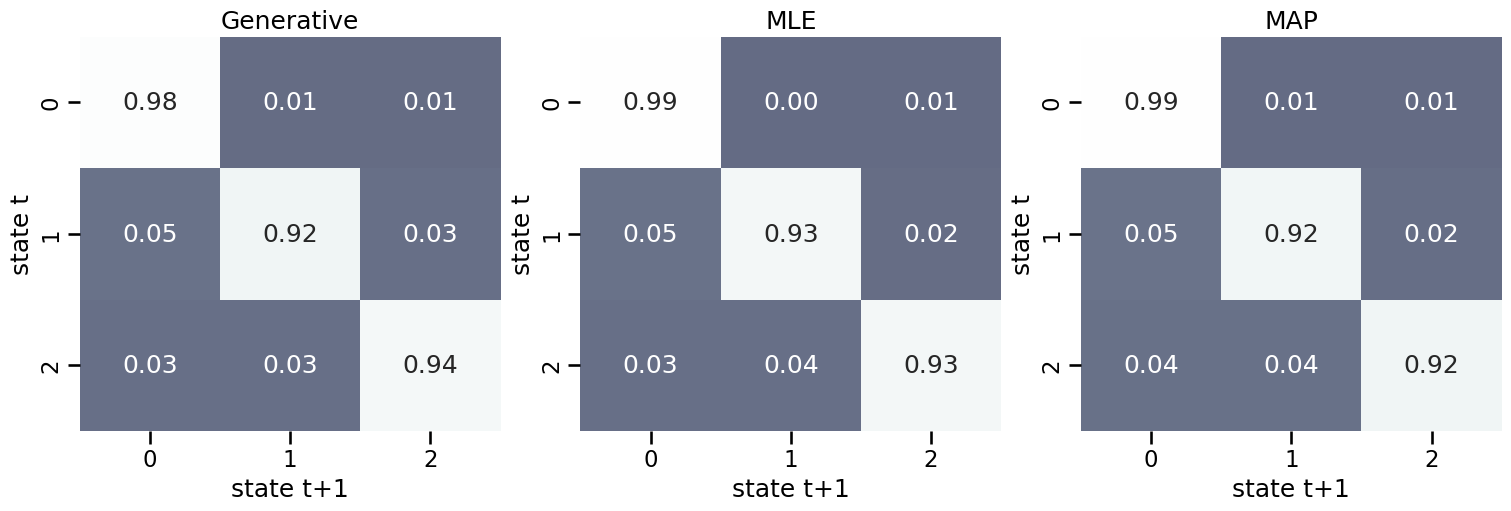

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True, edgecolor="k")

plot_transition_matrix(gen_log_trans_mat, ax[0], title="Generative")
plot_transition_matrix(new_glmhmm.transitions.log_Ps, ax[1], title="MLE")
plot_transition_matrix(map_glmhmm.transitions.log_Ps, ax[2], title="MAP")

## 6. Multinomial GLM-HMM

Until now, we have only considered the case where there are 2 output classes (the Bernoulli GLM-HMM corresponding to `C=num_categories=2`), yet the `ssm` framework is sufficiently general to allow us to fit the multinomial GLM-HMM described in Equations 1 and 2 and again below. Here we demonstrate a recovery analysis for the multinomial GLM-HMM. 

for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}} \tag{1}
\end{align}
$$


and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}} \tag{2}
\end{align}
$$


where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

### 6a. Initialize Multinomial GLM-HMM

In [100]:
# Set the parameters of the GLM-HMM
num_states = 4  # number of discrete states
obs_dim = 1  # number of observed dimensions
num_categories = 3  # number of categories for output
input_dim = 2  # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

### 6b. Specify Parameters of the Generative Model

In [101]:
# Set weights of multinomial GLM-HMM
gen_weights = np.array(
    [[[0.6, 3], [2, 3]], [[6, 1], [6, -2]], [[1, 1], [3, 1]], [[2, 2], [0, 5]]]
)
print(gen_weights.shape)
true_glmhmm.observations.params = gen_weights

(4, 2, 2)


In [102]:
# Set transition matrix of multinomial GLM-HMM
gen_log_trans_mat = np.log(
    np.array(
        [
            [
                [0.90, 0.04, 0.05, 0.01],
                [0.05, 0.92, 0.01, 0.02],
                [0.03, 0.02, 0.94, 0.01],
                [0.09, 0.01, 0.01, 0.89],
            ]
        ]
    )
)
true_glmhmm.transitions.params = gen_log_trans_mat

In the above, notice that the shape of the weights for the multinomial GLM-HMM is `(num_states, num_categories-1, input_dim)`.  Specifically, we only learn `num_categories-1` weight vectors (of size `input_dim`) for a given state, and we set the weights for the other observation class to zero. Constraining the weight vectors for one class is important if that we want to be able to identify generative weights in simulated data. If we didn't do this, it is easy to see that one could generate the same observation probabilities with a set of weight vectors that are offset by a constant vector $w_{k}$ (the index k indicates that a different offset vector could exist per state):
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{w_{kc'}^\mathsf{T} u_t\}} = \frac{\exp\{(w_{kc}-w_{k})^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{(w_{kc'}-w_{k})^\mathsf{T} u_t\}} \tag{7}
\end{align}
$$

Equations 1 and 2 at the top of this notebook already take into account the fact that the weights for a particular class for a given state are fixed to zero (this is why $c = C$ is handled differently). You can see this visualized below.


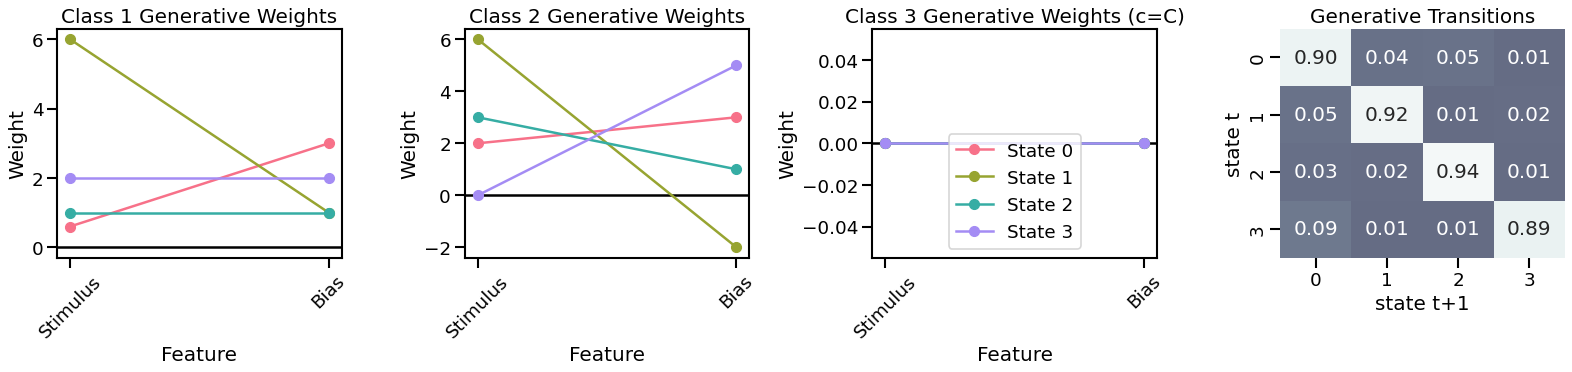

In [135]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=80)
plot_specified_class_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[0],
    title="Class 1 Generative Weights",
)
ax[0].get_legend().remove()

plot_specified_class_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=1,
    ax=ax[1],
    title="Class 2 Generative Weights",
)
ax[1].get_legend().remove()

plot_specified_class_weights_by_state(
    np.array([[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]),  # class 3 is set to 0
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[2],
    title="Class 3 Generative Weights (c=C)",
)


plot_transition_matrix(gen_log_trans_mat, ax=ax[3], title="Generative Transitions")

plt.tight_layout()

### 6c. Create External Input Sequences

In [136]:
# Create external inputs sequence; compared to the example above, we will increase the number of examples
# (through the "num_trials_per_session" paramater) since the number of parameters has increased
num_sess = 20  # number of example sessions
num_trials_per_sess = 1000  # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim))  # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:, :, 0] = np.random.choice(
    stim_vals, (num_sess, num_trials_per_sess)
)  # generate random sequence of stimuli
inpts = list(inpts)
print(
    f"input shapes, number of sessions: {len(inpts)}; trials, features: {inpts[0].shape}"
)

input shapes, number of sessions: 20; trials, features: (1000, 2)


### 6d. Simulate states and observations with generative model

In [137]:
# Generate a sequence of latents and choices for each session
true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

Note that y is not one-hot encoded here. Instead, it is a 0, 1 or 2 indicated the three num choices. I believe this ties back to the C - 1 weight vectors as well.

In [140]:
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts)
print("true ll = " + str(true_ll))

true ll = -16847.93667467945


Text(0, 0.5, 'observation class')

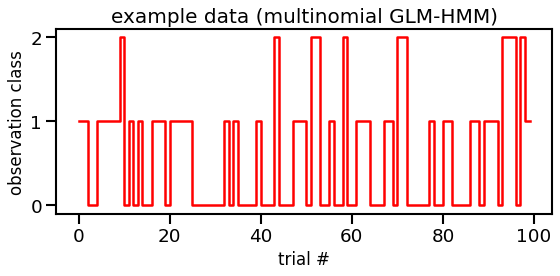

In [139]:
# plot example data:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor="w", edgecolor="k")
plt.step(range(100), true_choices[0][range(100)], color="red")
plt.yticks([0, 1, 2])
plt.title("example data (multinomial GLM-HMM)")
plt.xlabel("trial #", fontsize=15)
plt.ylabel("observation class", fontsize=15)

### 6e. Fit Multinomial GLM-HMM

In [142]:
# fit GLM-HMM
new_glmhmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

N_iters = 500  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(
    true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4
)

Converged to LP: -16837.8:  22%|██▏       | 108/500 [00:12<00:45,  8.60it/s]


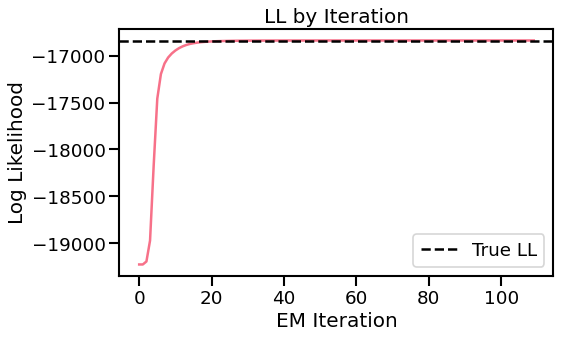

In [143]:
plot_log_likelihood_over_iters(fit_ll, true_ll=true_ll)

### 6f. Retrieved Parameters

In [145]:
# permute recovered state identities to match state identities of generative model
new_glmhmm.permute(
    find_permutation(
        true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])
    )
)

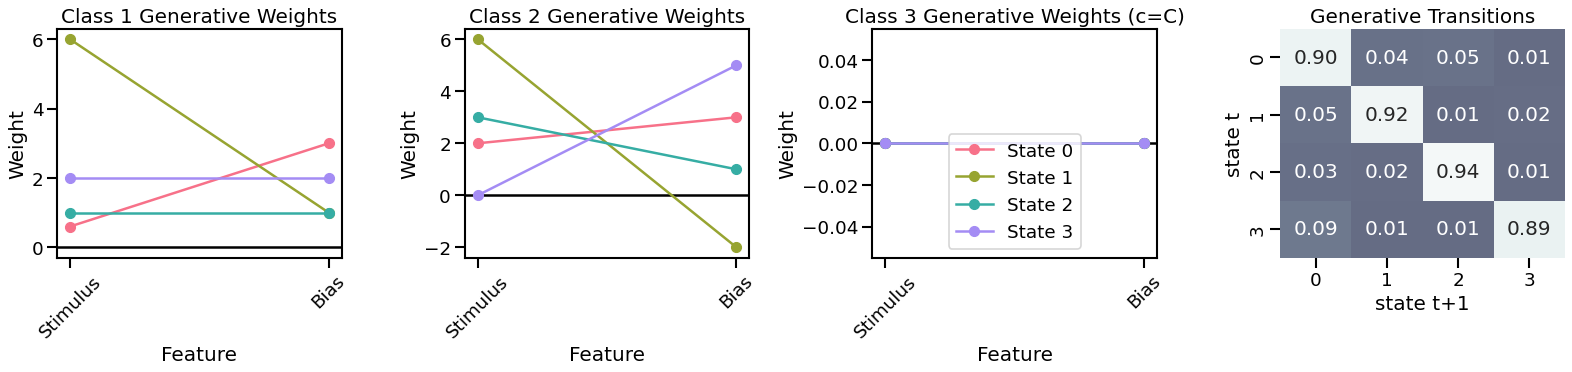

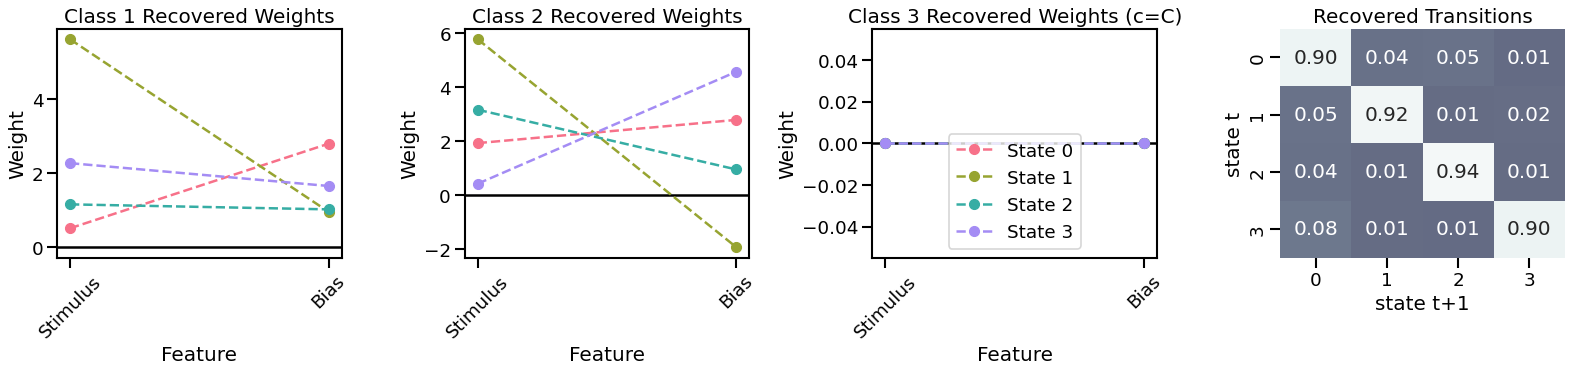

In [151]:
### GENERATIVE
fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=80)
plot_specified_class_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[0],
    title="Class 1 Generative Weights",
)
ax[0].get_legend().remove()

plot_specified_class_weights_by_state(
    gen_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=1,
    ax=ax[1],
    title="Class 2 Generative Weights",
)
ax[1].get_legend().remove()

plot_specified_class_weights_by_state(
    np.array([[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]),  # class 3 is set to 0
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[2],
    title="Class 3 Generative Weights (c=C)",
)

plot_transition_matrix(gen_log_trans_mat, ax=ax[3], title="Generative Transitions")
plt.tight_layout()

### RECOVERED
recovered_weights = new_glmhmm.observations.params
recovered_log_trans_mat = new_glmhmm.transitions.params[0]

fig, ax = plt.subplots(1, 4, figsize=(20, 5), dpi=80)
plot_specified_class_weights_by_state(
    recovered_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[0],
    linestyle="--",
    title="Class 1 Recovered Weights",
)
ax[0].get_legend().remove()

plot_specified_class_weights_by_state(
    recovered_weights,
    feature_names=["Stimulus", "Bias"],
    class_idx=1,
    ax=ax[1],
    linestyle="--",
    title="Class 2 Recovered Weights",
)
ax[1].get_legend().remove()

plot_specified_class_weights_by_state(
    np.array([[[0, 0]], [[0, 0]], [[0, 0]], [[0, 0]]]),  # class 3 is set to 0
    feature_names=["Stimulus", "Bias"],
    class_idx=0,
    ax=ax[2],
    linestyle="--",
    title="Class 3 Recovered Weights (c=C)",
)

plot_transition_matrix(recovered_log_trans_mat, ax=ax[3], title="Recovered Transitions")
plt.tight_layout()

Notebook is complete. My biggest concern is the weights = C-1. I wonder if the model is capable of fitting C = W weights. It is worth running a separate notebook to see if this is possible. This requires one-hot encoding the choice vectors I believe. 

Some ways to do this:
* step through the fitting code and see how it treats c = C. are vectors one hot encoded? 
* simulate a model with a C x M weight matrix and assess results in a seperate notebook.
